In [1]:
import torch
import torch.nn as nn
import pandas as pd
from tqdm.notebook import tqdm  # For displaying progress bars
from datasets import load_dataset  # For loading datasets
from sklearn.model_selection import train_test_split  # For splitting the dataset
from transformers import BertTokenizer  # For tokenizing text
from torch.utils.data import TensorDataset  # For creating Tensor datasets
import time  # For measuring time
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score  # For evaluation metrics
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from sklearn.exceptions import UndefinedMetricWarning  # For handling metric warnings
import seaborn as sns
import matplotlib.pyplot as plt  # For plotting
from tabulate import tabulate  # For tabular data formatting
import random  # For randomization
import numpy as np  # For numerical operations
from transformers import (
    BertTokenizer,  # Tokenizer for BERT models
    AdamW,  # Optimizer for BERT models
    get_linear_schedule_with_warmup,  # Learning rate scheduler for BERT models
    BertConfig,  # Configuration for BERT models
    BertForSequenceClassification  # BERT model for sequence classification tasks
)
from torch.utils.data import (
    DataLoader,  # Data loader for creating batches
    RandomSampler,  # Sampler for random sampling of data
    SequentialSampler  # Sampler for sequential sampling of data
)
from sklearn.metrics import f1_score  # For computing the F1 score

# 1. Torch: PyTorch library for deep learning
# 2. Pandas: Library for data manipulation and analysis
# 3. tqdm: Library for displaying progress bars
# 4. datasets: Library for working with datasets
# 5. train_test_split: Function for splitting the dataset into training and validation sets
# 6. BertTokenizer: Tokenizer for BERT models
# 7. TensorDataset: Dataset class for creating PyTorch Tensor datasets
# 8. time: Module for measuring time
# 9. accuracy_score, precision_score, f1_score: Evaluation metrics for classification tasks
# 10. UndefinedMetricWarning: Warning for undefined metric values
# 11. matplotlib.pyplot: Plotting library
# 12. tabulate: Library for formatting tabular data
# 13. random: Module for randomization
# 14. numpy: Library for numerical operations
# 15. AdamW: Optimizer for BERT models
# 16. get_linear_schedule_with_warmup: Learning rate scheduler for BERT models
# 17. BertConfig: Configuration for BERT models
# 18. BertForSequenceClassification: BERT model for sequence classification tasks
# 19. DataLoader: Data loader for creating batches
# 20. RandomSampler: Sampler for random sampling of data
# 21. SequentialSampler: Sampler for sequential sampling of data
# 22. f1_score: Function for computing the F1 score

2023-07-14 15:24:25.001312: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-14 15:24:25.028680: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-14 15:24:25.680443: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def data_sst2():
    dataset = load_dataset("sst2")
    train_data = dataset['train']
    validation_data = dataset['validation']

    df_train = train_data.to_pandas()  # Convert the training dataset to a Pandas DataFrame
    df_val = validation_data.to_pandas()  # Convert the validation dataset to a Pandas DataFrame

    df_train['sentiment'] = df_train['label'].map({0: 'bad', 1: 'good'})
    df_val['sentiment'] = df_val['label'].map({0: 'bad', 1: 'good'})

    possible_labels = df_train.sentiment.unique()  # Get unique category labels from the training DataFrame column 'category'

    label_dict = {}  # Create a dictionary to map each possible label to a unique index
    for index, possible_label in enumerate(possible_labels):
        label_dict[possible_label] = index

    df_train['label'] = df_train.sentiment.replace(label_dict)
    df_val['label'] = df_val.sentiment.replace(label_dict)

    df_train['data_type'] = 'train'  # Set the 'data_type' column to 'train' for training data
    df_val['data_type'] = 'val'  # Set the 'data_type' column to 'val' for validation data

    df = pd.concat([df_train, df_val], ignore_index=True)  # Merge the training and validation dataframes

    return df

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten() #This line finds the index with the highest probability in each prediction, effectively giving the predicted class for each input.
    labels_flat = labels.flatten()  #This line flattens the labels array into a 1D vector, as required by the f1_score function.
    return f1_score(labels_flat, preds_flat, average='weighted') #This line computes the F1 score using the true labels and the predicted labels, with the weighted averaging scheme. The result is returned.

def accuracy_per_class(preds, labels, label_dict):
    # Create a dictionary with keys and values reversed for easy lookup.
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    # Get the predicted labels and flatten them.
    preds_flat = np.argmax(preds, axis=1).flatten()
    
    # Get the actual labels and flatten them.
    labels_flat = labels.flatten()

    # Initialize the confusion matrix.
    confusion_matrix = np.zeros((len(label_dict), len(label_dict)), dtype=int)

    # Iterate over the unique labels in the actual labels.
    for label in np.unique(labels_flat):
        # Get the predicted labels for this class.
        y_preds = preds_flat[labels_flat==label]
        
        # Get the actual labels for this class.
        y_true = labels_flat[labels_flat==label]
        
        # Count the number of correct predictions for this class.
        num_correct = len(y_preds[y_preds==label])
        
        # Count the number of instances for this class.
        num_instances = len(y_true)
        
        # Calculate the accuracy percentage.
        accuracy = num_correct / num_instances * 100
        
        # Update the confusion matrix.
        confusion_matrix[label, label] = num_correct
        confusion_matrix[label, :] += np.bincount(y_preds, minlength=len(label_dict))
        
        # Print the class name, accuracy numerator and denominator.
        class_name = label_dict_inverse[label]
        print(f'Class: {class_name}')
        print(f'Accuracy: {num_correct}/{num_instances} ({accuracy:.2f}%)\n')

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix - Accuracy Percentage")
    plt.show()

#This code evaluates the performance of a trained model on a validation dataset by computing its loss and predictions for each batch in the dataset.
def evaluate(dataloader_val):

    model.eval() # setting the model to evaluation mode to disable dropout and other regularization techniques that are useful during training but not during evaluation.
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
    
        batch = tuple(b.to(device) for b in batch) # moving the input batch to the GPU for faster computation.
   
        #  creating a dictionary of inputs that will be passed to the model. The input IDs and attention mask are for the BERT model, and the labels are the true labels for each input.
        inputs = {'input_ids':  	batch[0],
                'attention_mask': batch[1],
                'labels':     	batch[2],
                } 

        with torch.no_grad():   
            outputs = model(**inputs)
        
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val)
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
       	 
    return loss_val_avg, predictions, true_vals

def train_model(trainer, dataloader_train, dataloader_val, epochs, patience):
    total_training_time = 0
    
    training_loss_list = []
    validation_loss_list = []
    accuracy_list = []
    precision_list = []
    f1_score_list = []
    
    previous_results = None  # Store previous epoch results
    best_val_loss = float('inf')
    counter = 0
    
    for epoch in tqdm(range(1, epochs + 1)):
        start_time = time.time()
    
        model.train()
        loss_train_total = 0
    
        progress_bar = tqdm(dataloader_train,
                            desc='Epoch {:1d}'.format(epoch),
                            leave=False,
                            disable=False)
        for batch in progress_bar:
            model.zero_grad()
            batch = tuple(b.to(device) for b in batch)
            inputs = {
                'input_ids': batch[0],
                'attention_mask': batch[1],
                'labels': batch[2],
            }
            output = model(**inputs)
            loss = output[0]

            # L1 regularization
            l1_regularization = torch.tensor(0., device=device)
            for param in model.parameters():
                l1_regularization += torch.norm(param, 1)
            
            # L2 regularization
            l2_regularization = torch.tensor(0., device=device)
            for param in model.parameters():
                l2_regularization += torch.norm(param, 2)

            
            loss_train_total += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(batch))})
    
        end_time = time.time()
        epoch_training_time = end_time - start_time
        total_training_time += epoch_training_time
    
        torch.save(model.state_dict(), f'Models/finetuned_gpt_bert_sst2_ft_epoch{epoch}.model')
    
        tqdm.write(f'\nEpoch {epoch}')
    
        loss_train_avg = loss_train_total / len(dataloader_train)
        tqdm.write(f'Training loss: {loss_train_avg}')
    
        val_loss, predictions, true_vals = evaluate(dataloader_val)
    
        # Convert predictions to discrete labels
        predictions = np.argmax(predictions, axis=1)
    
        val_f1 = f1_score(true_vals, predictions, average='weighted')
        tqdm.write(f'Validation loss: {val_loss}')
        tqdm.write(f'F1 Score (weighted): {val_f1}')
    
        val_accuracy = accuracy_score(true_vals, predictions)
        val_precision = precision_score(true_vals, predictions, average='weighted', zero_division=1)
    
        # Compute and store metrics
        training_loss_list.append(loss_train_avg)
        validation_loss_list.append(val_loss)
        f1_score_list.append(val_f1)
        accuracy_list.append(val_accuracy)
        precision_list.append(val_precision)
    
        # Check if there are previous results to compare with
        if previous_results is not None:
            if loss_train_avg > previous_results['loss_train_avg']:
                percentage_increase = ((loss_train_avg - previous_results['loss_train_avg']) / previous_results['loss_train_avg']) * 100
                tqdm.write('\033[91m' + f'{round(percentage_increase, 2)}% Training loss increased compared to the previous epoch' + '\033[0m')
            if loss_train_avg < previous_results['loss_train_avg']:
                percentage_decrease = ((previous_results['loss_train_avg'] - loss_train_avg) / previous_results['loss_train_avg']) * 100
                tqdm.write('\033[92m' + f'{round(percentage_decrease, 2)}% Training loss decreased compared to the previous epoch' + '\033[0m')
            if val_loss > previous_results['val_loss']:
                percentage_increase = ((val_loss - previous_results['val_loss']) / previous_results['val_loss']) * 100
                tqdm.write('\033[91m' + f'{round(percentage_increase, 2)}% Validation loss increased compared to the previous epoch' + '\033[0m')
            if val_loss < previous_results['val_loss']:
                percentage_decrease = ((previous_results['val_loss'] - val_loss) / previous_results['val_loss']) * 100
                tqdm.write('\033[92m' + f'{round(percentage_decrease, 2)}% Validation loss decreased compared to the previous epoch' + '\033[0m')
            if val_f1 < previous_results['val_f1']:
                percentage_decrease = ((previous_results['val_f1'] - val_f1) / previous_results['val_f1']) * 100
                tqdm.write('\033[91m' + f'{round(percentage_decrease, 2)}% F1 Score decreased compared to the previous epoch' + '\033[0m')
            if val_f1 > previous_results['val_f1']:
                percentage_increase = ((val_f1 - previous_results['val_f1']) / previous_results['val_f1']) * 100
                tqdm.write('\033[92m' + f'{round(percentage_increase, 2)}% F1 Score increased compared to the previous epoch' + '\033[0m')
    
        # Store current results as previous results for the next epoch
        previous_results = {
            'loss_train_avg': loss_train_avg,
            'val_loss': val_loss,
            'val_f1': val_f1
        }
        
        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                tqdm.write('\nEarly stopping triggered. Training stopped.')
                break
    
    total_time_minutes = total_training_time / 60
    tqdm.write(f'\nTotal training time: {total_time_minutes} minutes')
    
    final_accuracy = accuracy_list[-1]
    final_precision = precision_list[-1]
    tqdm.write(f'Final Accuracy: {final_accuracy}')
    tqdm.write(f'Final Precision: {final_precision}')
    
    # Create the x-axis values based on the actual number of epochs completed
    x_values = range(1, len(training_loss_list) + 1)
    
    # Create the metrics subplot
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot training loss
    ax.plot(x_values, training_loss_list, label='Training Loss')
    
    # Plot validation loss
    ax.plot(x_values, validation_loss_list, label='Validation Loss')
    
    # Plot F1-score
    ax.plot(x_values, f1_score_list, label='F1 Score')

    # Plot Accuracy
    ax.plot(x_values, accuracy_list, label='Accuracy')
    
    # Set labels and title
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Metric Value')
    ax.set_title('Training Loss, Validation Loss, and F1 Score')
    
    # Set legend
    ax.legend()
    
    # Show the combined plot
    plt.show()
    
    
    # Create the metrics table
    metrics_table = [
        ['Epoch', 'Training Loss', 'Validation Loss', 'F1 Score', 'Accuracy', 'Precision'],
    ]
    previous_results = None
    for epoch in range(1, len(training_loss_list) + 1):
        row = [
            epoch,
            training_loss_list[epoch - 1],
            validation_loss_list[epoch - 1],
            f1_score_list[epoch - 1],
            accuracy_list[epoch - 1],
            precision_list[epoch - 1]
        ]
    
        # Compare with previous epoch results
        if previous_results is not None:
            if training_loss_list[epoch - 1] < previous_results['loss_train_avg']:
                row[1] = '\033[92m' + str(row[1]) + '\033[0m'  # Highlight in green
            if training_loss_list[epoch - 1] > previous_results['loss_train_avg']:
                row[1] = '\033[91m' + str(row[1]) + '\033[0m'  # Highlight in red
            if validation_loss_list[epoch - 1] < previous_results['val_loss']:
                row[2] = '\033[92m' + str(row[2]) + '\033[0m'  # Highlight in green
            if validation_loss_list[epoch - 1] > previous_results['val_loss']:
                row[2] = '\033[91m' + str(row[2]) + '\033[0m'  # Highlight in red
            if f1_score_list[epoch - 1] > previous_results['val_f1']:
                row[3] = '\033[92m' + str(row[3]) + '\033[0m'  # Highlight in green
            if f1_score_list[epoch - 1] < previous_results['val_f1']:
                row[3] = '\033[91m' + str(row[3]) + '\033[0m'  # Highlight in red
            if accuracy_list[epoch - 1] > previous_results['val_f1']:
                row[4] = '\033[92m' + str(row[3]) + '\033[0m'  # Highlight in green
            if accuracy_list[epoch - 1] < previous_results['val_f1']:
                row[4] = '\033[91m' + str(row[3]) + '\033[0m'  # Highlight in red
            if precision_list[epoch - 1] > previous_results['val_f1']:
                row[5] = '\033[92m' + str(row[3]) + '\033[0m'  # Highlight in green
            if precision_list[epoch - 1] < previous_results['val_f1']:
                row[5] = '\033[91m' + str(row[3]) + '\033[0m'  # Highlight in red
    
        metrics_table.append(row)
        previous_results = {
            'loss_train_avg': training_loss_list[epoch - 1],
            'val_loss': validation_loss_list[epoch - 1],
            'val_f1': f1_score_list[epoch - 1]
        }
    
    # Calculate total training time in minutes
    total_time_minutes = total_training_time / 60
    
    # Calculate total precision
    total_precision = precision_list[-1]
    
    # Add total training time and total precision rows to the table
    metrics_table.append(['Total Training Time', '', '', '', '', total_training_time])
    metrics_table.append(['Final Precision', '', '', '', '', total_precision])
    metrics_table.append(['Total Time (minutes)', '', '', '', '', total_time_minutes])
    
    # Print the table
    print(tabulate(metrics_table, headers='firstrow'))

default_args = {
    "output_dir": "tmp",
    "evaluation_strategy": "steps",
    "num_train_epochs": 1,
    "log_level": "error",
    "report_to": "none",
}

In [3]:
df = data_sst2()

Found cached dataset sst2 (/home/z123010/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
# Create label_dict and assign the number of labels
label_dict = {label: index for index, label in enumerate(df['label'].unique())}

In [5]:
df.sample(n=10, random_state=42)  # Generate 10 random rows from df

,idx,sentence,label,sentiment,data_type
1990,1990,the best script,1,good,train
26513,26513,vividly back,1,good,train
54185,54185,than most third-rate horror sequels,0,bad,train
48479,48479,", byler reveals the ways in which a sultry eve...",1,good,train
14682,14682,"is funny , charming and quirky",1,good,train
24245,24245,"a whole lot of fun and funny in the middle , t...",1,good,train
60561,60561,the most screwy thing here is how so many tale...,0,bad,train
42157,42157,"dreary , humorless soap opera",0,bad,train
19912,19912,"will take you places you have n't been , and a...",1,good,train
50295,50295,interesting and at times captivating,1,good,train


In [6]:
df.groupby(['sentiment']).count()

,idx,sentence,label,data_type
sentiment,,,,
bad,30208,30208,30208,30208
good,38013,38013,38013,38013


In [7]:
# Load BERT tokenizer
pretrained_path = 'bert-base-uncased'  # Replace with the path to the pretrained BERT model
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case=True
)

encoded_data_train_text = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].sentence.values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='longest',
    max_length=256,
    truncation=True,
    return_tensors='pt'
)

input_ids_train = encoded_data_train_text['input_ids']
attention_masks_train = encoded_data_train_text['attention_mask']

labels_train = torch.tensor(df[df.data_type=='train'].label.values)

encoded_data_val_text = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].sentence.values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='longest',
    max_length=256,
    truncation=True,
    return_tensors='pt'
)

input_ids_val = encoded_data_val_text['input_ids']
attention_masks_val = encoded_data_val_text['attention_mask']

labels_val = torch.tensor(df[df.data_type=='val'].label.values)

In [8]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)
len(dataset_train), len(dataset_val)

(67349, 872)

In [9]:
from transformers import BertModel, BertConfig, GPT2Model, GPT2Config

num_classes = 2

class SentimentModel(nn.Module):
    def __init__(self, pretrained_bert_path, pretrained_gpt_path):
        super(SentimentModel, self).__init__()

        gpt_config = GPT2Config.from_pretrained(
            pretrained_gpt_path,
            hidden_dropout_prob=0.3,
            attention_probs_dropout_prob=0.1,
            num_hidden_layers=6  # Set the number of GPT layers to 6
        )
        self.gpt = GPT2Model.from_pretrained(pretrained_gpt_path, config=gpt_config)
        
        bert_config = BertConfig.from_pretrained(pretrained_bert_path)
        bert_config.num_hidden_layers = 6  # Set the number of BERT layers to 6
        self.bert = BertModel.from_pretrained(pretrained_bert_path, config=bert_config)
        
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(bert_config.hidden_size + gpt_config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask, labels=None):
        gpt_outputs = self.gpt(input_ids, attention_mask=attention_mask)[0]
        bert_outputs = self.bert(input_ids, attention_mask=attention_mask)[0]
        
        gpt_last_hidden_state = self.dropout(gpt_outputs[:, -1, :])  # Use the last hidden state
        bert_pooled_output = self.dropout(bert_outputs[:, 0, :])  # Use the [CLS] token representation
        
        combined_outputs = torch.cat((gpt_last_hidden_state, bert_pooled_output), dim=1)
        
        logits = self.fc(combined_outputs)
        outputs = nn.functional.softmax(logits, dim=1)
        
        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits.view(-1, num_classes), labels.view(-1))
            return loss, outputs, labels
        else:
            return outputs


In [10]:
# Create model instance
model = SentimentModel('bert-base-uncased', 'gpt2')

Some weights of the model checkpoint at gpt2 were not used when initializing GPT2Model: ['h.6.mlp.c_fc.bias', 'h.8.ln_1.bias', 'h.10.ln_1.weight', 'h.8.ln_1.weight', 'h.7.ln_1.weight', 'h.10.attn.c_proj.bias', 'h.9.mlp.c_proj.weight', 'h.8.mlp.c_fc.bias', 'h.8.mlp.c_proj.bias', 'h.7.mlp.c_fc.weight', 'h.10.mlp.c_proj.bias', 'h.10.mlp.c_fc.weight', 'h.8.attn.c_proj.weight', 'h.6.mlp.c_fc.weight', 'h.11.mlp.c_fc.weight', 'h.6.ln_2.weight', 'h.6.attn.c_attn.weight', 'h.10.mlp.c_proj.weight', 'h.10.ln_1.bias', 'h.10.attn.c_proj.weight', 'h.11.attn.c_attn.bias', 'h.10.mlp.c_fc.bias', 'h.6.mlp.c_proj.bias', 'h.9.mlp.c_fc.weight', 'h.6.attn.c_attn.bias', 'h.11.ln_2.weight', 'h.9.ln_2.weight', 'h.6.ln_2.bias', 'h.11.mlp.c_proj.weight', 'h.9.attn.c_proj.weight', 'h.8.mlp.c_proj.weight', 'h.11.attn.c_proj.bias', 'h.9.attn.c_attn.bias', 'h.11.mlp.c_proj.bias', 'h.7.attn.c_proj.bias', 'h.8.attn.c_proj.bias', 'h.9.attn.c_proj.bias', 'h.7.attn.c_attn.bias', 'h.7.ln_2.bias', 'h.8.ln_2.bias', 'h.9.ln_

In [11]:
# Define the regularization strength
lambda_l1 = 0.001
lambda_l2 = 0.001
# Define the loss function
criterion = nn.CrossEntropyLoss()

In [12]:
# Set device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SentimentModel(
  (gpt): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings

In [13]:
from transformers import TrainingArguments, Trainer, logging
training_args = TrainingArguments(
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    gradient_checkpointing=True,
    fp16=True,
    **default_args,
)

In [14]:
trainer = Trainer(
model=model,
args=training_args,
train_dataset=dataset_train,
)

In [15]:
batch_size = 8 #32

dataloader_val = DataLoader(
    dataset_val,
    sampler=RandomSampler(dataset_val),
    batch_size=1
)

In [16]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(
    model.parameters(),
    lr=1e-5,
    eps=1e-8
)

epochs = 50
patience = 10
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(dataloader_train) * epochs
)

/home/z123010/anaconda3/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [17]:
import random

seed_val = 17
random.seed(seed_val) #sets the seed value for the Python built-in pseudo-random generator.
np.random.seed(seed_val) #sets the seed value for the NumPy pseudo-random number generator.
torch.manual_seed(seed_val) #sets the seed value for the random number generator in PyTorch on the CPU.
torch.cuda.manual_seed_all(seed_val) #sets the seed value for the random number generator in PyTorch on the GPU.

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda



Fold 1


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.3104116148345023
Validation loss: 0.2163239945784751
F1 Score (weighted): 0.9375502474760874


Epoch 2:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.1904553214118857
Validation loss: 0.2059934710660831
F1 Score (weighted): 0.949833863750143
38.64% Training loss decreased compared to the previous epoch
4.78% Validation loss decreased compared to the previous epoch
1.31% F1 Score increased compared to the previous epoch


Epoch 3:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.13692209716857842
Validation loss: 0.2296808772046757
F1 Score (weighted): 0.9505968844789128
28.11% Training loss decreased compared to the previous epoch
11.5% Validation loss increased compared to the previous epoch
0.08% F1 Score increased compared to the previous epoch


Epoch 4:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.10290485386805308
Validation loss: 0.25595748644038413
F1 Score (weighted): 0.9505861214145218
24.84% Training loss decreased compared to the previous epoch
11.44% Validation loss increased compared to the previous epoch
0.0% F1 Score decreased compared to the previous epoch


Epoch 5:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.07904462039139305
Validation loss: 0.30895021993361477
F1 Score (weighted): 0.949828123035827
23.19% Training loss decreased compared to the previous epoch
20.7% Validation loss increased compared to the previous epoch
0.08% F1 Score decreased compared to the previous epoch


Epoch 6:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.06169082302529286
Validation loss: 0.34655956579619274
F1 Score (weighted): 0.9500275784322815
21.95% Training loss decreased compared to the previous epoch
12.17% Validation loss increased compared to the previous epoch
0.02% F1 Score increased compared to the previous epoch


Epoch 7:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.050123340232816976
Validation loss: 0.3960207746477618
F1 Score (weighted): 0.9481524877445235
18.75% Training loss decreased compared to the previous epoch
14.27% Validation loss increased compared to the previous epoch
0.2% F1 Score decreased compared to the previous epoch


Epoch 8:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.04208238223988608
Validation loss: 0.378369717626459
F1 Score (weighted): 0.9495031847949296
16.04% Training loss decreased compared to the previous epoch
4.46% Validation loss decreased compared to the previous epoch
0.14% F1 Score increased compared to the previous epoch


Epoch 9:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.03476714596231995
Validation loss: 0.42542610733421293
F1 Score (weighted): 0.9480586754348618
17.38% Training loss decreased compared to the previous epoch
12.44% Validation loss increased compared to the previous epoch
0.15% F1 Score decreased compared to the previous epoch


Epoch 10:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.028685200987588148
Validation loss: 0.479752210344995
F1 Score (weighted): 0.9468634363655422
17.49% Training loss decreased compared to the previous epoch
12.77% Validation loss increased compared to the previous epoch
0.13% F1 Score decreased compared to the previous epoch


Epoch 11:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.025851170371575576
Validation loss: 0.4768535523882421
F1 Score (weighted): 0.9460100678043893
9.88% Training loss decreased compared to the previous epoch
0.6% Validation loss decreased compared to the previous epoch
0.09% F1 Score decreased compared to the previous epoch


Epoch 12:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 12
Training loss: 0.022330817550441227
Validation loss: 0.47730435259192705
F1 Score (weighted): 0.9464370792507513
13.62% Training loss decreased compared to the previous epoch
0.09% Validation loss increased compared to the previous epoch
0.05% F1 Score increased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 156.28316930532455 minutes
Final Accuracy: 0.9463994060876021
Final Precision: 0.9465326153155026


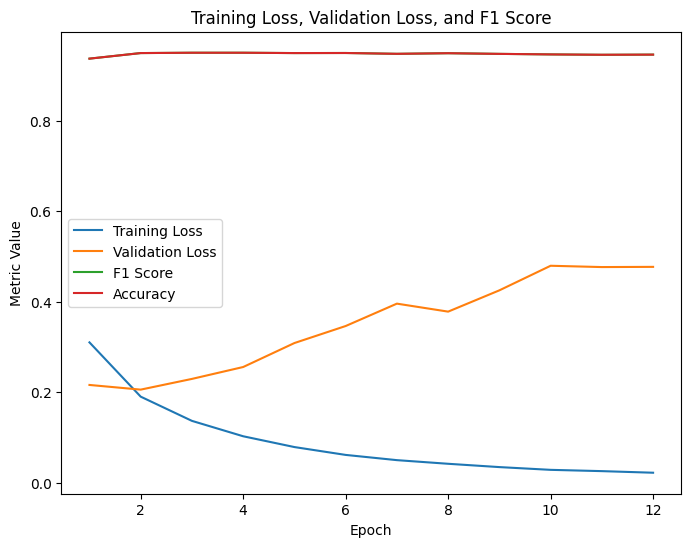

Epoch                 Training Loss         Validation Loss      F1 Score            Accuracy              Precision
--------------------  --------------------  -------------------  ------------------  ------------------  -----------
1                     0.3104116148345023    0.2163239945784751   0.9375502474760874  0.9374907201187824     0.937719
2                     0.1904553214118857    0.2059934710660831   0.949833863750143   0.949833863750143      0.949834
3                     0.13692209716857842   0.2296808772046757   0.9505968844789128  0.9505968844789128     0.950597
4                     0.10290485386805308   0.25595748644038413  0.9505861214145218  0.9505861214145218     0.950586
5                     0.07904462039139305   0.30895021993361477  0.949828123035827   0.949828123035827      0.949828
6                     0.06169082302529286   0.34655956579619274  0.9500275784322815  0.9500275784322815     0.950028
7                     0.050123340232816976  0.3960207746477618  

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.05210946563912635
Validation loss: 0.013066854728630527
F1 Score (weighted): 0.9965847092383866


Epoch 2:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.02930541390675637
Validation loss: 0.027387702465611712
F1 Score (weighted): 0.9943566536946911
43.76% Training loss decreased compared to the previous epoch
109.6% Validation loss increased compared to the previous epoch
0.22% F1 Score decreased compared to the previous epoch


Epoch 3:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.02212623057917823
Validation loss: 0.03749218390707171
F1 Score (weighted): 0.9933192792610684
24.5% Training loss decreased compared to the previous epoch
36.89% Validation loss increased compared to the previous epoch
0.1% F1 Score decreased compared to the previous epoch


Epoch 4:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.015233884520093662
Validation loss: 0.03448764662807133
F1 Score (weighted): 0.9945062160794271
31.15% Training loss decreased compared to the previous epoch
8.01% Validation loss decreased compared to the previous epoch
0.12% F1 Score increased compared to the previous epoch


Epoch 5:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.014446745394973124
Validation loss: 0.040577087620261194
F1 Score (weighted): 0.9943574435200783
5.17% Training loss decreased compared to the previous epoch
17.66% Validation loss increased compared to the previous epoch
0.01% F1 Score decreased compared to the previous epoch


Epoch 6:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.011095218979066221
Validation loss: 0.049410855061986746
F1 Score (weighted): 0.9925766010273603
23.2% Training loss decreased compared to the previous epoch
21.77% Validation loss increased compared to the previous epoch
0.18% F1 Score decreased compared to the previous epoch


Epoch 7:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.009502196512707528
Validation loss: 0.05866964431935487
F1 Score (weighted): 0.9915348307011909
14.36% Training loss decreased compared to the previous epoch
18.74% Validation loss increased compared to the previous epoch
0.1% F1 Score decreased compared to the previous epoch


Epoch 8:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.009678478352502334
Validation loss: 0.043771714218731626
F1 Score (weighted): 0.9937645556690821
1.86% Training loss increased compared to the previous epoch
25.39% Validation loss decreased compared to the previous epoch
0.22% F1 Score increased compared to the previous epoch


Epoch 9:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.006899472263458672
Validation loss: 0.05953820624466082
F1 Score (weighted): 0.9925758399834199
28.71% Training loss decreased compared to the previous epoch
36.02% Validation loss increased compared to the previous epoch
0.12% F1 Score decreased compared to the previous epoch


Epoch 10:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.00799834832832661
Validation loss: 0.05675167297191568
F1 Score (weighted): 0.9919799378538708
15.93% Training loss increased compared to the previous epoch
4.68% Validation loss decreased compared to the previous epoch
0.06% F1 Score decreased compared to the previous epoch


Epoch 11:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.005723472628143159
Validation loss: 0.0635622322671747
F1 Score (weighted): 0.9910888198376342
28.44% Training loss decreased compared to the previous epoch
12.0% Validation loss increased compared to the previous epoch
0.09% F1 Score decreased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 142.70273809035618 minutes
Final Accuracy: 0.9910913140311804
Final Precision: 0.9910976693783404


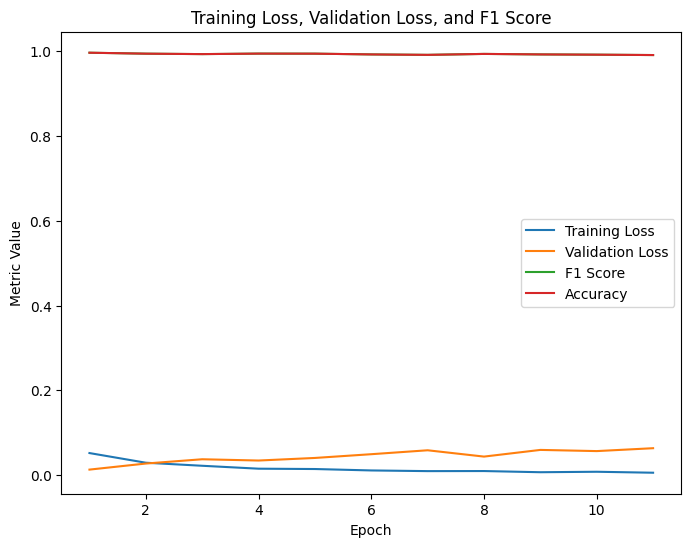

Epoch                 Training Loss         Validation Loss       F1 Score            Accuracy              Precision
--------------------  --------------------  --------------------  ------------------  ------------------  -----------
1                     0.05210946563912635   0.013066854728630527  0.9965847092383866  0.9965850037119525     0.996586
2                     0.02930541390675637   0.027387702465611712  0.9943566536946911  0.9943566536946911     0.994357
3                     0.02212623057917823   0.03749218390707171   0.9933192792610684  0.9933192792610684     0.993319
4                     0.015233884520093662  0.03448764662807133   0.9945062160794271  0.9945062160794271     0.994506
5                     0.014446745394973124  0.040577087620261194  0.9943574435200783  0.9943574435200783     0.994357
6                     0.011095218979066221  0.049410855061986746  0.9925766010273603  0.9925766010273603     0.992577
7                     0.009502196512707528  0.0586696443

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.011999629534561039
Validation loss: 0.001762355659288855
F1 Score (weighted): 0.9995545564954404


Epoch 2:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.006126708018610533
Validation loss: 0.005823733007299846
F1 Score (weighted): 0.9991090203062714
48.94% Training loss decreased compared to the previous epoch
230.45% Validation loss increased compared to the previous epoch
0.04% F1 Score decreased compared to the previous epoch


Epoch 3:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.0064574287504368015
Validation loss: 0.007447863730593856
F1 Score (weighted): 0.9988120766731071
5.4% Training loss increased compared to the previous epoch
27.89% Validation loss increased compared to the previous epoch
0.03% F1 Score decreased compared to the previous epoch


Epoch 4:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.005366503620135967
Validation loss: 0.004888846964252592
F1 Score (weighted): 0.9991090575048305
16.89% Training loss decreased compared to the previous epoch
34.36% Validation loss decreased compared to the previous epoch
0.03% F1 Score increased compared to the previous epoch


Epoch 5:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.00445714142742921
Validation loss: 0.004238613550113598
F1 Score (weighted): 0.9991090575048305
16.95% Training loss decreased compared to the previous epoch
13.3% Validation loss decreased compared to the previous epoch


Epoch 6:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.004251394618458054
Validation loss: 0.00536732359407548
F1 Score (weighted): 0.9992576248115097
4.62% Training loss decreased compared to the previous epoch
26.63% Validation loss increased compared to the previous epoch
0.01% F1 Score increased compared to the previous epoch


Epoch 7:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.004400200364411809
Validation loss: 0.007494149947553031
F1 Score (weighted): 0.9988121752041574
3.5% Training loss increased compared to the previous epoch
39.63% Validation loss increased compared to the previous epoch
0.04% F1 Score decreased compared to the previous epoch


Epoch 8:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.0033206065354174723
Validation loss: 0.008138614640665372
F1 Score (weighted): 0.9986636694863211
24.54% Training loss decreased compared to the previous epoch
8.6% Validation loss increased compared to the previous epoch
0.01% F1 Score decreased compared to the previous epoch


Epoch 9:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.0030180263192866033
Validation loss: 0.0043758154616241425
F1 Score (weighted): 0.9989605454140656
9.11% Training loss decreased compared to the previous epoch
46.23% Validation loss decreased compared to the previous epoch
0.03% F1 Score increased compared to the previous epoch


Epoch 10:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.0027024752719922935
Validation loss: 0.007363198936865614
F1 Score (weighted): 0.9988120766731071
10.46% Training loss decreased compared to the previous epoch
68.27% Validation loss increased compared to the previous epoch
0.01% F1 Score decreased compared to the previous epoch


Epoch 11:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.0029971725016332933
Validation loss: 0.008149685439918553
F1 Score (weighted): 0.9986636140626168
10.9% Training loss increased compared to the previous epoch
10.68% Validation loss increased compared to the previous epoch
0.01% F1 Score decreased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 142.5885240594546 minutes
Final Accuracy: 0.9986636971046771
Final Precision: 0.9986639349119809


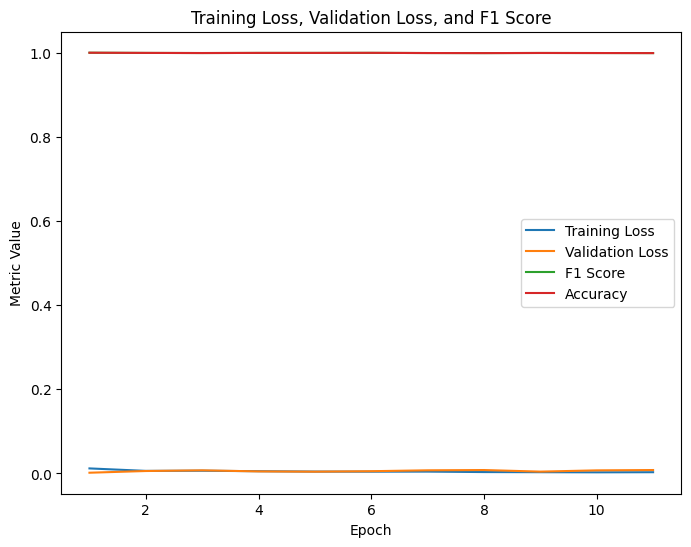

Epoch                 Training Loss          Validation Loss        F1 Score            Accuracy              Precision
--------------------  ---------------------  ---------------------  ------------------  ------------------  -----------
1                     0.011999629534561039   0.001762355659288855   0.9995545564954404  0.999554565701559      0.999555
2                     0.006126708018610533   0.005823733007299846   0.9991090203062714  0.9991090203062714     0.999109
3                     0.0064574287504368015  0.007447863730593856   0.9988120766731071  0.9988120766731071     0.998812
4                     0.005366503620135967   0.004888846964252592   0.9991090575048305  0.9991090575048305     0.999109
5                     0.00445714142742921    0.004238613550113598   0.9991090575048305  0.9991090575048305     0.999109
6                     0.004251394618458054   0.00536732359407548    0.9992576248115097  0.9992576248115097     0.999258
7                     0.0044002003644118

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.0035199479904041175
Validation loss: 9.52590063678786e-05
F1 Score (weighted): 1.0


Epoch 2:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.0016126407039298214
Validation loss: 0.0011633041325089218
F1 Score (weighted): 0.9998515193194423
54.19% Training loss decreased compared to the previous epoch
1121.2% Validation loss increased compared to the previous epoch
0.01% F1 Score decreased compared to the previous epoch


Epoch 3:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.001351284181337471
Validation loss: 0.0021368535982418347
F1 Score (weighted): 0.9998515193194423
16.21% Training loss decreased compared to the previous epoch
83.69% Validation loss increased compared to the previous epoch


Epoch 4:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.002178299110351193
Validation loss: 5.988271542051765e-05
F1 Score (weighted): 1.0
61.2% Training loss increased compared to the previous epoch
97.2% Validation loss decreased compared to the previous epoch
0.01% F1 Score increased compared to the previous epoch


Epoch 5:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.002044550697421531
Validation loss: 2.121530291807384e-05
F1 Score (weighted): 1.0
6.14% Training loss decreased compared to the previous epoch
64.57% Validation loss decreased compared to the previous epoch


Epoch 6:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.0006960039648563293
Validation loss: 2.8059797552729764e-05
F1 Score (weighted): 1.0
65.96% Training loss decreased compared to the previous epoch
32.26% Validation loss increased compared to the previous epoch


Epoch 7:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.001117306254164978
Validation loss: 3.660360112564048e-05
F1 Score (weighted): 1.0
60.53% Training loss increased compared to the previous epoch
30.45% Validation loss increased compared to the previous epoch


Epoch 8:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.0016639960840612888
Validation loss: 5.8540423852832916e-05
F1 Score (weighted): 1.0
48.93% Training loss increased compared to the previous epoch
59.93% Validation loss increased compared to the previous epoch


Epoch 9:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.001067560568772301
Validation loss: 3.461086470254852e-05
F1 Score (weighted): 1.0
35.84% Training loss decreased compared to the previous epoch
40.88% Validation loss decreased compared to the previous epoch


Epoch 10:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.0007979295442236584
Validation loss: 1.3103207768598636e-05
F1 Score (weighted): 1.0
25.26% Training loss decreased compared to the previous epoch
62.14% Validation loss decreased compared to the previous epoch


Epoch 11:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.0013947979310845618
Validation loss: 2.708482953425245e-05
F1 Score (weighted): 1.0
74.8% Training loss increased compared to the previous epoch
106.7% Validation loss increased compared to the previous epoch


Epoch 12:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 12
Training loss: 0.000415208162603311
Validation loss: 2.1677743445353412e-05
F1 Score (weighted): 1.0
70.23% Training loss decreased compared to the previous epoch
19.96% Validation loss decreased compared to the previous epoch


Epoch 13:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 13
Training loss: 0.0008640089617347763
Validation loss: 2.0152956889747028e-05
F1 Score (weighted): 1.0
108.09% Training loss increased compared to the previous epoch
7.03% Validation loss decreased compared to the previous epoch


Epoch 14:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 14
Training loss: 0.0006552255278314949
Validation loss: 3.970101768085104e-05
F1 Score (weighted): 1.0
24.16% Training loss decreased compared to the previous epoch
97.0% Validation loss increased compared to the previous epoch


Epoch 15:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 15
Training loss: 0.0004164449135262292
Validation loss: 1.950809545932634e-05
F1 Score (weighted): 1.0
36.44% Training loss decreased compared to the previous epoch
50.86% Validation loss decreased compared to the previous epoch


Epoch 16:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 16
Training loss: 0.0003775077269369834
Validation loss: 2.0174941468975635e-05
F1 Score (weighted): 1.0
9.35% Training loss decreased compared to the previous epoch
3.42% Validation loss increased compared to the previous epoch


Epoch 17:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 17
Training loss: 0.00028596866215432063
Validation loss: 1.5033875866543325e-05
F1 Score (weighted): 1.0
24.25% Training loss decreased compared to the previous epoch
25.48% Validation loss decreased compared to the previous epoch


Epoch 18:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 18
Training loss: 0.0004134373274673378
Validation loss: 2.092396241073591e-05
F1 Score (weighted): 1.0
44.57% Training loss increased compared to the previous epoch
39.18% Validation loss increased compared to the previous epoch


Epoch 19:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 19
Training loss: 0.0007645652661630058
Validation loss: 1.765931916422069e-05
F1 Score (weighted): 1.0
84.93% Training loss increased compared to the previous epoch
15.6% Validation loss decreased compared to the previous epoch


Epoch 20:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 20
Training loss: 0.00027377261807475916
Validation loss: 2.1229612254586056e-05
F1 Score (weighted): 1.0
64.19% Training loss decreased compared to the previous epoch
20.22% Validation loss increased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 259.30121465524036 minutes
Final Accuracy: 1.0
Final Precision: 1.0


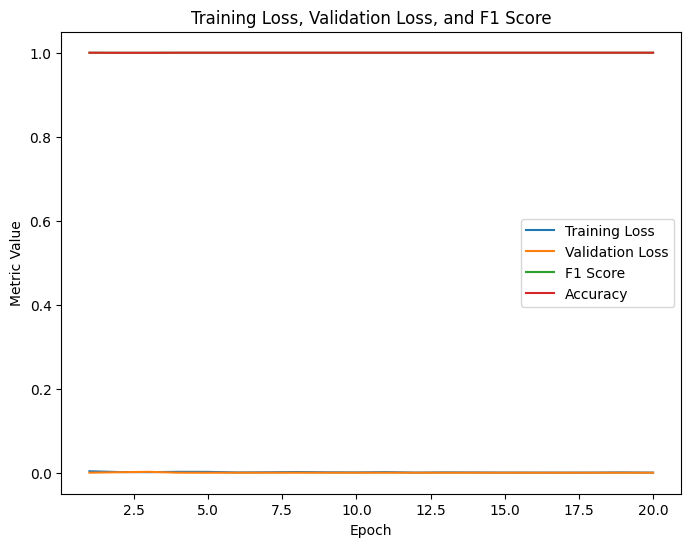

Epoch                 Training Loss           Validation Loss         F1 Score            Accuracy               Precision
--------------------  ----------------------  ----------------------  ------------------  ------------------  ------------
1                     0.0035199479904041175   9.52590063678786e-05    1.0                 1.0                     1
2                     0.0016126407039298214   0.0011633041325089218   0.9998515193194423  0.9998515193194423      0.999852
3                     0.001351284181337471    0.0021368535982418347   0.9998515193194423  0.9998515193194423      0.999852
4                     0.002178299110351193    5.988271542051765e-05   1.0                 1.0                     1
5                     0.002044550697421531    2.121530291807384e-05   1.0                 1.0                     1
6                     0.0006960039648563293   2.8059797552729764e-05  1.0                 1.0                     1
7                     0.001117306254164978  

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.0011189633515254044
Validation loss: 0.0004326543240531236
F1 Score (weighted): 0.9995545586307448


Epoch 2:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.0003956959065774836
Validation loss: 0.00043315547482994794
F1 Score (weighted): 0.9995545586307448
64.64% Training loss decreased compared to the previous epoch
0.12% Validation loss increased compared to the previous epoch


Epoch 3:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.000633802535097988
Validation loss: 0.00043315548241442623
F1 Score (weighted): 0.9995545586307448
60.17% Training loss increased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 4:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.00019173992093818293
Validation loss: 0.00043315547482986353
F1 Score (weighted): 0.9995545586307448
69.75% Training loss decreased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 5:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.00039687909178121153
Validation loss: 0.00043315547735792734
F1 Score (weighted): 0.9995545586307448
106.99% Training loss increased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 6:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.0007905719083682677
Validation loss: 0.00043315547735797797
F1 Score (weighted): 0.9995545586307448
99.2% Training loss increased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 7:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.00036911294073433516
Validation loss: 0.00043315547482982976
F1 Score (weighted): 0.9995545586307448
53.31% Training loss decreased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 8:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.0006088639099090154
Validation loss: 0.0004331554798862274
F1 Score (weighted): 0.9995545586307448
64.95% Training loss increased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 9:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.00034484446603171796
Validation loss: 0.00043315547735823113
F1 Score (weighted): 0.9995545586307448
43.36% Training loss decreased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 10:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.000230703186064657
Validation loss: 0.00043315547735831554
F1 Score (weighted): 0.9995545586307448
33.1% Training loss decreased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 11:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.0003680636027072088
Validation loss: 0.000433155474829931
F1 Score (weighted): 0.9995545586307448
59.54% Training loss increased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 142.66111061175664 minutes
Final Accuracy: 0.999554565701559
Final Precision: 0.9995545961308615


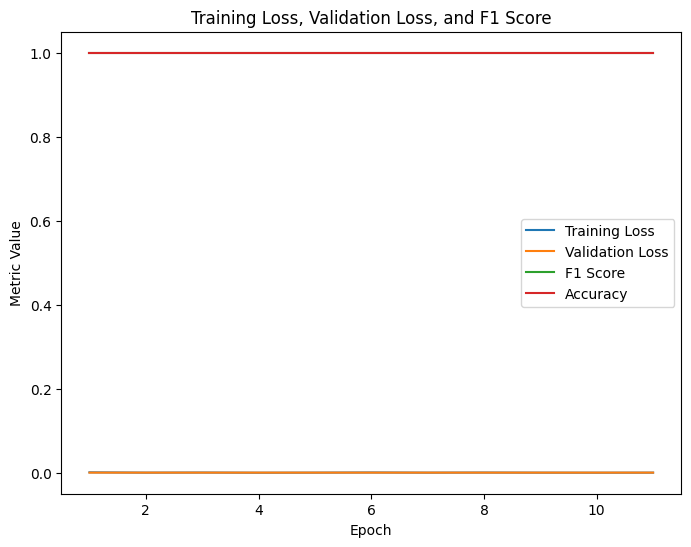

Epoch                 Training Loss           Validation Loss         F1 Score            Accuracy              Precision
--------------------  ----------------------  ----------------------  ------------------  ------------------  -----------
1                     0.0011189633515254044   0.0004326543240531236   0.9995545586307448  0.999554565701559      0.999555
2                     0.0003956959065774836   0.00043315547482994794  0.9995545586307448  0.9995545586307448     0.999555
3                     0.000633802535097988    0.00043315548241442623  0.9995545586307448  0.9995545586307448     0.999555
4                     0.00019173992093818293  0.00043315547482986353  0.9995545586307448  0.9995545586307448     0.999555
5                     0.00039687909178121153  0.00043315547735792734  0.9995545586307448  0.9995545586307448     0.999555
6                     0.0007905719083682677   0.00043315547735797797  0.9995545586307448  0.9995545586307448     0.999555
7                     0.

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.0005251361058079844
Validation loss: 2.5197724782087236e-07
F1 Score (weighted): 1.0


Epoch 2:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.0005135328799341443
Validation loss: 2.5197471953766805e-07
F1 Score (weighted): 1.0
2.21% Training loss decreased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 3:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.0002434614798883367
Validation loss: 2.519772476014649e-07
F1 Score (weighted): 1.0
52.59% Training loss decreased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 4:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.00031223119174582587
Validation loss: 2.5197724783774987e-07
F1 Score (weighted): 1.0
28.25% Training loss increased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 5:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.0005541641585308886
Validation loss: 2.519772476520974e-07
F1 Score (weighted): 1.0
77.49% Training loss increased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 6:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.0004968637311756201
Validation loss: 2.5197471913260805e-07
F1 Score (weighted): 1.0
10.34% Training loss decreased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 7:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.0002827706957708412
Validation loss: 2.5197471950391305e-07
F1 Score (weighted): 1.0
43.09% Training loss decreased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 8:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.0004160482650819073
Validation loss: 2.5197471936889303e-07
F1 Score (weighted): 1.0
47.13% Training loss increased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 9:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.00037650879579996364
Validation loss: 2.5197471955454555e-07
F1 Score (weighted): 1.0
9.5% Training loss decreased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 10:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.0003943541104394678
Validation loss: 2.5197977578340424e-07
F1 Score (weighted): 1.0
4.74% Training loss increased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 11:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.000858381783786233
Validation loss: 2.519772476352199e-07
F1 Score (weighted): 1.0
117.67% Training loss increased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 12:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 12
Training loss: 0.00046186967322082843
Validation loss: 2.5197471965581057e-07
F1 Score (weighted): 1.0
46.19% Training loss decreased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 13:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 13
Training loss: 0.0007686605090680917
Validation loss: 2.519797758171592e-07
F1 Score (weighted): 1.0
66.42% Training loss increased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 14:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 14
Training loss: 0.0005133508517447063
Validation loss: 2.5197471950391305e-07
F1 Score (weighted): 1.0
33.21% Training loss decreased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 15:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 15
Training loss: 0.00047227631118832016
Validation loss: 2.5197471952079055e-07
F1 Score (weighted): 1.0
8.0% Training loss decreased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 16:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 16
Training loss: 0.00048803211756003284
Validation loss: 2.519747193520156e-07
F1 Score (weighted): 1.0
3.34% Training loss increased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 207.5020532210668 minutes
Final Accuracy: 1.0
Final Precision: 1.0


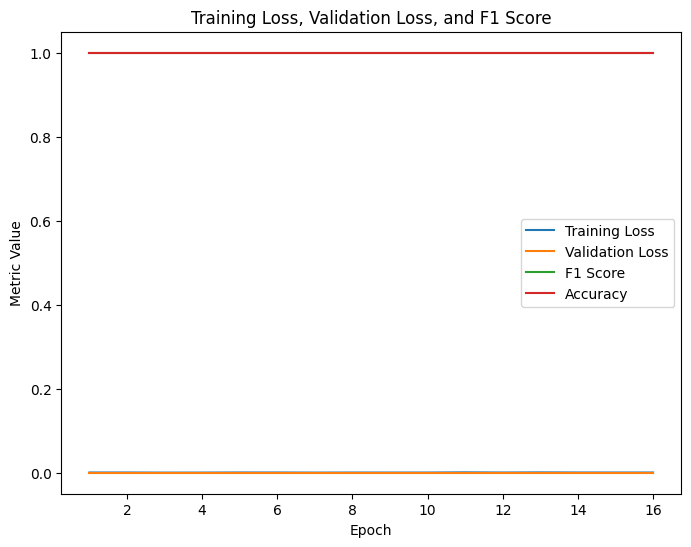

Epoch                 Training Loss           Validation Loss         F1 Score    Accuracy      Precision
--------------------  ----------------------  ----------------------  ----------  ----------  -----------
1                     0.0005251361058079844   2.5197724782087236e-07  1.0         1.0               1
2                     0.0005135328799341443   2.5197471953766805e-07  1.0         1.0               1
3                     0.0002434614798883367   2.519772476014649e-07   1.0         1.0               1
4                     0.00031223119174582587  2.5197724783774987e-07  1.0         1.0               1
5                     0.0005541641585308886   2.519772476520974e-07   1.0         1.0               1
6                     0.0004968637311756201   2.5197471913260805e-07  1.0         1.0               1
7                     0.0002827706957708412   2.5197471950391305e-07  1.0         1.0               1
8                     0.0004160482650819073   2.5197471936889303e-07  1.0 

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.0006604545544784249
Validation loss: 0.00017966276957056266
F1 Score (weighted): 1.0


Epoch 2:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.0007549772264579159
Validation loss: 0.0001796627695705289
F1 Score (weighted): 1.0
14.31% Training loss increased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 3:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.001057239720385213
Validation loss: 0.0001796627695704614
F1 Score (weighted): 1.0
40.04% Training loss increased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 4:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.0006757438219446337
Validation loss: 0.0001796627771550072
F1 Score (weighted): 1.0
36.08% Training loss decreased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 5:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.00025693542519920865
Validation loss: 0.0001796627695707652
F1 Score (weighted): 1.0
61.98% Training loss decreased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 6:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.0004429417039937289
Validation loss: 0.00017966276957066392
F1 Score (weighted): 1.0
72.39% Training loss increased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 7:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.0008433007507789878
Validation loss: 0.00017966276957049514
F1 Score (weighted): 1.0
90.39% Training loss increased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 8:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.0008819477623178297
Validation loss: 0.0001796627695704614
F1 Score (weighted): 1.0
4.58% Training loss increased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 9:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.000808298590332648
Validation loss: 0.00017966277209862646
F1 Score (weighted): 1.0
8.35% Training loss decreased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 10:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.0008410301405804336
Validation loss: 0.00017966276957020823
F1 Score (weighted): 1.0
4.05% Training loss increased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 11:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.00017877161787439278
Validation loss: 0.00017966276957057955
F1 Score (weighted): 1.0
78.74% Training loss decreased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 12:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 12
Training loss: 0.0006389258921106258
Validation loss: 0.00017966276957084957
F1 Score (weighted): 1.0
257.4% Training loss increased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 13:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 13
Training loss: 0.00044843497504631
Validation loss: 0.00017966276957057955
F1 Score (weighted): 1.0
29.81% Training loss decreased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 14:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 14
Training loss: 0.00013003334980155656
Validation loss: 0.0001796627695703095
F1 Score (weighted): 1.0
71.0% Training loss decreased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 15:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 15
Training loss: 0.0003939551486072298
Validation loss: 0.0001796627695706808
F1 Score (weighted): 1.0
202.96% Training loss increased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 16:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 16
Training loss: 0.0003382887349239585
Validation loss: 0.00017966276957079893
F1 Score (weighted): 1.0
14.13% Training loss decreased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 17:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 17
Training loss: 0.0004570823620653058
Validation loss: 0.00017966276957069767
F1 Score (weighted): 1.0
35.12% Training loss increased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 18:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 18
Training loss: 0.00048277663232422345
Validation loss: 0.00017966277209876147
F1 Score (weighted): 1.0
5.62% Training loss increased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 19:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 19
Training loss: 0.00025515633652202014
Validation loss: 0.0001796627695705964
F1 Score (weighted): 1.0
47.15% Training loss decreased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 20:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 20
Training loss: 0.0004845017853163499
Validation loss: 0.00017966276957047828
F1 Score (weighted): 1.0
89.88% Training loss increased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 259.46725117762884 minutes
Final Accuracy: 1.0
Final Precision: 1.0


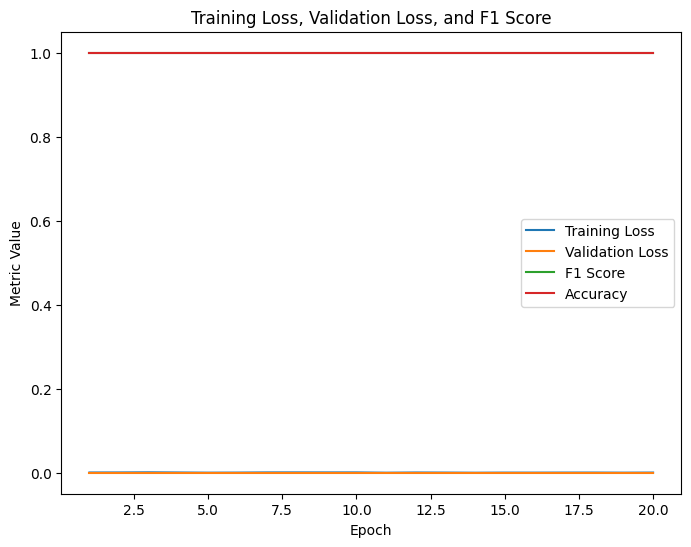

Epoch                 Training Loss           Validation Loss         F1 Score    Accuracy      Precision
--------------------  ----------------------  ----------------------  ----------  ----------  -----------
1                     0.0006604545544784249   0.00017966276957056266  1.0         1.0               1
2                     0.0007549772264579159   0.0001796627695705289   1.0         1.0               1
3                     0.001057239720385213    0.0001796627695704614   1.0         1.0               1
4                     0.0006757438219446337   0.0001796627771550072   1.0         1.0               1
5                     0.00025693542519920865  0.0001796627695707652   1.0         1.0               1
6                     0.0004429417039937289   0.00017966276957066392  1.0         1.0               1
7                     0.0008433007507789878   0.00017966276957049514  1.0         1.0               1
8                     0.0008819477623178297   0.0001796627695704614   1.0 

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.0007153405121550738
Validation loss: 4.8775641742037027e-05
F1 Score (weighted): 1.0


Epoch 2:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.0008589194322632314
Validation loss: 4.877564427052276e-05
F1 Score (weighted): 1.0
20.07% Training loss increased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 3:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.0001411342152700867
Validation loss: 4.8775641742256435e-05
F1 Score (weighted): 1.0
83.57% Training loss decreased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 4:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.0004731894262942159
Validation loss: 4.8775641742053906e-05
F1 Score (weighted): 1.0
235.28% Training loss increased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 5:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.0008485759118950244
Validation loss: 4.877564174217205e-05
F1 Score (weighted): 1.0
79.33% Training loss increased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 6:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.0006464431067112973
Validation loss: 4.877564174218892e-05
F1 Score (weighted): 1.0
23.82% Training loss decreased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 7:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.0005488277494593589
Validation loss: 4.877564174232395e-05
F1 Score (weighted): 1.0
15.1% Training loss decreased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 8:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.00035026685395723225
Validation loss: 4.877564427053964e-05
F1 Score (weighted): 1.0
36.18% Training loss decreased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 9:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.00047149654447962026
Validation loss: 4.8775641742256435e-05
F1 Score (weighted): 1.0
34.61% Training loss increased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 10:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.0006000907875876336
Validation loss: 4.8775649326616604e-05
F1 Score (weighted): 1.0
27.27% Training loss increased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 11:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.0003770775136530763
Validation loss: 4.877564427043838e-05
F1 Score (weighted): 1.0
37.16% Training loss decreased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 142.8036679784457 minutes
Final Accuracy: 1.0
Final Precision: 1.0


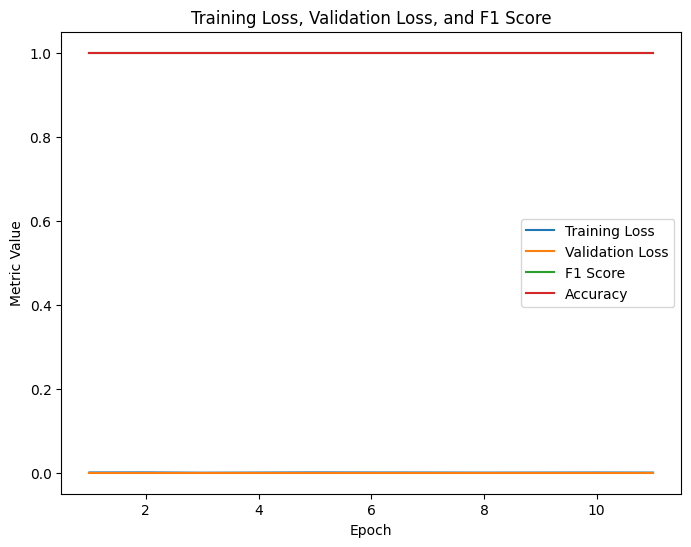

Epoch                 Training Loss           Validation Loss         F1 Score    Accuracy      Precision
--------------------  ----------------------  ----------------------  ----------  ----------  -----------
1                     0.0007153405121550738   4.8775641742037027e-05  1.0         1.0               1
2                     0.0008589194322632314   4.877564427052276e-05   1.0         1.0               1
3                     0.0001411342152700867   4.8775641742256435e-05  1.0         1.0               1
4                     0.0004731894262942159   4.8775641742053906e-05  1.0         1.0               1
5                     0.0008485759118950244   4.877564174217205e-05   1.0         1.0               1
6                     0.0006464431067112973   4.877564174218892e-05   1.0         1.0               1
7                     0.0005488277494593589   4.877564174232395e-05   1.0         1.0               1
8                     0.00035026685395723225  4.877564427053964e-05   1.0 

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.0004438017826298444
Validation loss: 0.00010064730060038784
F1 Score (weighted): 1.0


Epoch 2:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.000571738600914862
Validation loss: 0.00010064730565668421
F1 Score (weighted): 1.0
28.83% Training loss increased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 3:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.0006358525832670762
Validation loss: 0.00010064730312850227
F1 Score (weighted): 1.0
11.21% Training loss increased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 4:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.0005322355047336278
Validation loss: 0.00010064730060023595
F1 Score (weighted): 1.0
16.3% Training loss decreased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 5:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.0006132520149711364
Validation loss: 0.0001006473081846805
F1 Score (weighted): 1.0
15.22% Training loss increased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 6:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.0003706259498271788
Validation loss: 0.00010064730312851914
F1 Score (weighted): 1.0
39.56% Training loss decreased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 7:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.0006802252717790318
Validation loss: 0.00010064730818471425
F1 Score (weighted): 1.0
83.53% Training loss increased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 8:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.0005672515259040995
Validation loss: 0.00010064730565681923
F1 Score (weighted): 1.0
16.61% Training loss decreased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 9:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.0006589744225337439
Validation loss: 0.00010064730565665045
F1 Score (weighted): 1.0
16.17% Training loss increased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 10:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.00042815337686914463
Validation loss: 0.00010064730060013468
F1 Score (weighted): 1.0
35.03% Training loss decreased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 11:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.0003798505579924724
Validation loss: 0.00010064730565703863
F1 Score (weighted): 1.0
11.28% Training loss decreased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 12:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 12
Training loss: 0.0007258367375979221
Validation loss: 0.00010064730565649855
F1 Score (weighted): 1.0
91.08% Training loss increased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 13:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 13
Training loss: 0.0005079790899867743
Validation loss: 0.00010064730312821535
F1 Score (weighted): 1.0
30.01% Training loss decreased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 14:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 14
Training loss: 0.000395556596353869
Validation loss: 0.00010064730060042159
F1 Score (weighted): 1.0
22.13% Training loss decreased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 15:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 15
Training loss: 0.0007015678020420278
Validation loss: 0.00010064730312863729
F1 Score (weighted): 1.0
77.36% Training loss increased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 16:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 16
Training loss: 0.0003315071471479174
Validation loss: 0.00010064730312850227
F1 Score (weighted): 1.0
52.75% Training loss decreased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 17:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 17
Training loss: 0.00039130029044392653
Validation loss: 0.00010064730060030345
F1 Score (weighted): 1.0
18.04% Training loss increased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 18:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 18
Training loss: 0.0007748755889608242
Validation loss: 0.00010064730060043848
F1 Score (weighted): 1.0
98.03% Training loss increased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 19:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 19
Training loss: 0.0003558997914249023
Validation loss: 0.0001006473031285529
F1 Score (weighted): 1.0
54.07% Training loss decreased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 20:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 20
Training loss: 0.0004274540245268507
Validation loss: 0.00010064730818493366
F1 Score (weighted): 1.0
20.11% Training loss increased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 260.21837748289107 minutes
Final Accuracy: 1.0
Final Precision: 1.0


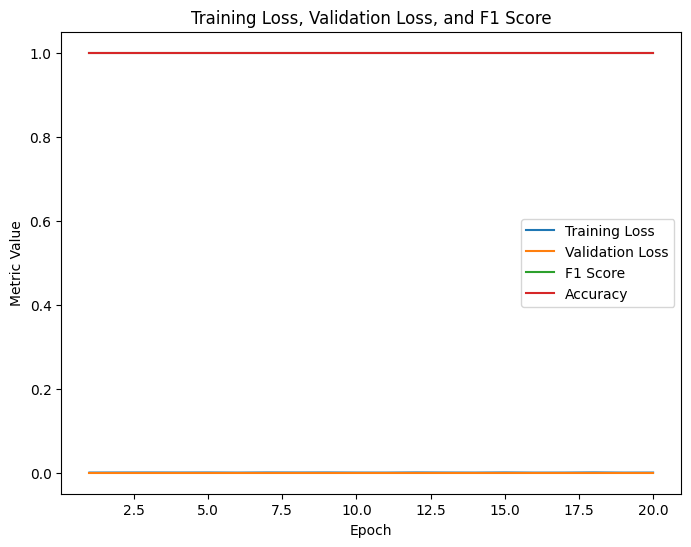

Epoch                 Training Loss           Validation Loss         F1 Score    Accuracy      Precision
--------------------  ----------------------  ----------------------  ----------  ----------  -----------
1                     0.0004438017826298444   0.00010064730060038784  1.0         1.0               1
2                     0.000571738600914862    0.00010064730565668421  1.0         1.0               1
3                     0.0006358525832670762   0.00010064730312850227  1.0         1.0               1
4                     0.0005322355047336278   0.00010064730060023595  1.0         1.0               1
5                     0.0006132520149711364   0.0001006473081846805   1.0         1.0               1
6                     0.0003706259498271788   0.00010064730312851914  1.0         1.0               1
7                     0.0006802252717790318   0.00010064730818471425  1.0         1.0               1
8                     0.0005672515259040995   0.00010064730565681923  1.0 

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.0007181679614054801
Validation loss: 0.0001898640891865071
F1 Score (weighted): 0.9998515020102231


Epoch 2:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.0003969865798923899
Validation loss: 0.0001898640832873315
F1 Score (weighted): 0.9998515020102231
44.72% Training loss decreased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 3:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.00012138827780689146
Validation loss: 0.00018986408328706148
F1 Score (weighted): 0.9998515020102231
69.42% Training loss decreased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 4:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.00031526530925377234
Validation loss: 0.00018986409508566578
F1 Score (weighted): 0.9998515020102231
159.72% Training loss increased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 5:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.00020650976573560655
Validation loss: 0.00018986408918630457
F1 Score (weighted): 0.9998515020102231
34.5% Training loss decreased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 6:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.0002885210398638753
Validation loss: 0.0001898640891864902
F1 Score (weighted): 0.9998515020102231
39.71% Training loss increased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 7:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.0002501841127246807
Validation loss: 0.00018986409508554765
F1 Score (weighted): 0.9998515020102231
13.29% Training loss decreased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 8:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.0004871084538644915
Validation loss: 0.00018986408328743276
F1 Score (weighted): 0.9998515020102231
94.7% Training loss increased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 9:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.000239543595596673
Validation loss: 0.00018986408918632142
F1 Score (weighted): 0.9998515020102231
50.82% Training loss decreased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 10:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.0003043404858738522
Validation loss: 0.00018986408918638894
F1 Score (weighted): 0.9998515020102231
27.05% Training loss increased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 11:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.0003108531200856861
Validation loss: 0.00018986408328760154
F1 Score (weighted): 0.9998515020102231
2.14% Training loss increased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 12:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 12
Training loss: 0.0005647755326816366
Validation loss: 0.00018986408328739901
F1 Score (weighted): 0.9998515020102231
81.69% Training loss increased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 13:   0%|          | 0/7577 [00:00<?, ?it/s]


Epoch 13
Training loss: 0.00018510781942366857
Validation loss: 0.00018986408328744965
F1 Score (weighted): 0.9998515020102231
67.22% Training loss decreased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 168.55146065155665 minutes
Final Accuracy: 0.9998514998514999
Final Precision: 0.9998515486841696


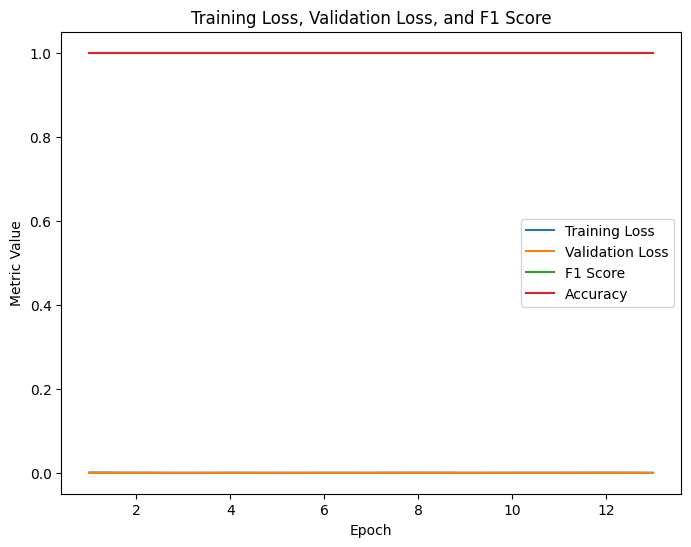

Epoch                 Training Loss           Validation Loss         F1 Score            Accuracy               Precision
--------------------  ----------------------  ----------------------  ------------------  ------------------  ------------
1                     0.0007181679614054801   0.0001898640891865071   0.9998515020102231  0.9998514998514999      0.999852
2                     0.0003969865798923899   0.0001898640832873315   0.9998515020102231  0.9998515020102231      0.999852
3                     0.00012138827780689146  0.00018986408328706148  0.9998515020102231  0.9998515020102231      0.999852
4                     0.00031526530925377234  0.00018986409508566578  0.9998515020102231  0.9998515020102231      0.999852
5                     0.00020650976573560655  0.00018986408918630457  0.9998515020102231  0.9998515020102231      0.999852
6                     0.0002885210398638753   0.0001898640891864902   0.9998515020102231  0.9998515020102231      0.999852
7               

In [19]:
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold

k = 10  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize lists to store the evaluation metrics for each fold
training_loss_lists = []
validation_loss_lists = []
accuracy_lists = []
precision_lists = []
f1_score_lists = []

# Convert the multilabel indicator target to numpy array
targets = dataset_train.tensors[1].numpy()

# Perform multilabel k-fold cross-validation
for fold, (train_index, val_index) in enumerate(kf.split(targets)):
    print(f"\nFold {fold+1}")
    train_sampler = SubsetRandomSampler(train_index)
    val_sampler = SubsetRandomSampler(val_index)

    # Create data loaders for training and validation
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, sampler=train_sampler)
    dataloader_vals = DataLoader(dataset_train, batch_size=batch_size, sampler=val_sampler)

    # train_model(trainer, dataloader_train, dataloader_val, epochs, patience)

    try:
        train_model(trainer, dataloader_train, dataloader_vals, epochs, patience)
    except Exception as e:
        print(f"Continue to the next fold {fold+1}: {str(e)}")
        continue

Class: 0
Accuracy: 378/428 (88.32%)

Class: 1
Accuracy: 400/444 (90.09%)



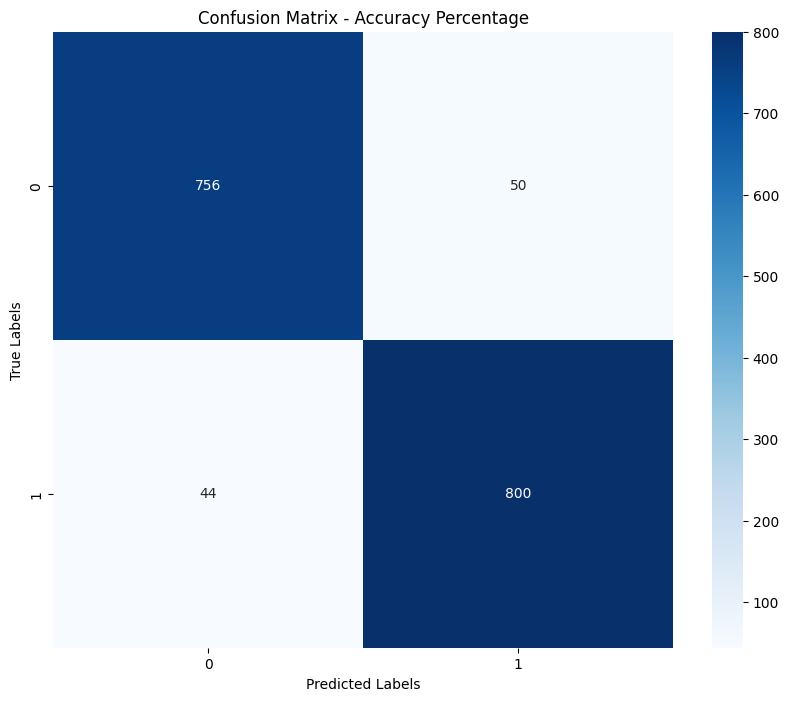

In [29]:
model.load_state_dict(
    torch.load(
        "Models/finetuned_gpt_bert_sst2_ft_epoch20.model", 
        map_location = torch.device('cuda')
    )
)
_, predictions, true_vals = evaluate(dataloader_val)
accuracy_per_class(predictions, true_vals, label_dict)